## Modelling for Center Backs

### Preprocessing

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import numpy as np

final_df = pd.read_csv("plch_uncorr_elo_v2.csv")

# 1. Filter for "Att Mid / Wingers"
df_cb = final_df[final_df["Position"] == "Center Backs"].copy()

df_cb

,Player,Birthdate,League,Club,Footed,Nationality,Position,Minutes,Goals,Assists,...,Carries into Penalty Area,Miscontrols,Dispossessed,Fouls Committed,Fouls Drawn,Offsides,Ball Recoveries,Aerials Won,overall,Elo
1,Virgil van Dijk,1991-07-08,PremierLeague,Liverpool,Right,Netherlands,Center Backs,3330,0.08,0.03,...,0.08,0.27,0.14,0.46,0.35,0.00,3.11,3.22,90,1993
4,Ibrahima Konaté,1999-05-25,PremierLeague,Liverpool,Right,France,Center Backs,2560,0.04,0.07,...,0.00,0.28,0.07,0.95,0.70,0.00,3.45,2.60,85,1993
15,William Saliba,2001-03-24,PremierLeague,Arsenal,Right,France,Center Backs,3039,0.06,0.00,...,0.03,0.56,0.24,0.83,0.50,0.03,4.56,1.81,87,1993
19,Gabriel Magalhães,1997-12-19,PremierLeague,Arsenal,Left,Brazil,Center Backs,2363,0.11,0.04,...,0.00,0.34,0.08,0.72,0.72,0.00,2.40,2.02,87,1993
28,Jakub Kiwior,2000-02-15,PremierLeague,Arsenal,Left,Poland,Center Backs,1122,0.08,0.00,...,0.08,0.24,0.16,0.80,0.32,0.08,2.49,0.88,76,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,Nikola Katić,1996-10-10,EFLChampionship,Plymouth Argyle,Right,Bosnia and Herzegovina,Center Backs,1223,0.07,0.00,...,0.00,1.03,0.07,1.25,0.52,0.00,2.94,5.74,69,1443
604,Calum Chambers,1995-01-20,EFLChampionship,Cardiff City,Right,England,Center Backs,3513,0.05,0.03,...,0.03,0.92,0.51,1.36,0.36,0.08,4.48,2.23,72,1434
605,Dimitris Goutas,1994-04-04,EFLChampionship,Cardiff City,Right,Greece,Center Backs,2919,0.03,0.03,...,0.00,0.46,0.06,0.59,0.19,0.03,2.65,3.14,72,1434
611,Joel Bagan,2000-05-07,EFLChampionship,Cardiff City,Left,Republic of Ireland,Center Backs,1612,0.00,0.06,...,0.22,0.34,0.34,1.12,0.73,0.00,3.96,1.01,63,1434


In [2]:
# 2. Define target and input features //
target = "overall"
drop_cols = ["Player", "Birthdate", "League", "Club", "Nationality", "Footed", "Position", "Minutes", "Club_x", "Aerials Lost", "Errors"]

center_backs_features = [
    'Goals', 'Assists',                                # Set piece threat
    'Pass Completion %', 'Pass Completion % (Long)',   # Build-up reliability
    'Progressive Passes', 'Progressive Passing Distance', # Line-breaking passes
    'Passes Attempted (Long)',                         # Direct balls out of defense
    'Blocks', 'Shots Blocked',                         # Shot prevention
    'Tackles (Def 3rd)', 'Tackles (Mid 3rd)',          # Defensive duels in own/mid half
    'Tkl+Int',                                         # Ball-winning
    'Aerials Won',                                     # Dominance in the air
    'Ball Recoveries',                                 # Sweeping up behind line
    'Fouls Committed', 'Yellow Cards', 'Red Cards',    # Discipline and aggression
    'Touches (Def 3rd)',                               # Involvement in deep build-up
    'GCA (Defensive Action)',                          # Direct defensive goal involvement
    'SCA (Defensive Action)',                          # Direct defensive shot prevention
    'Elo'                                              # Context
]

In [3]:
X = df_cb.drop(columns=drop_cols + [target], errors="ignore")
X = df_cb[center_backs_features].copy()
y = df_cb[target]
numeric_features = X.select_dtypes(include="number").columns.tolist()


# 3. Preprocessing pipeline // min-maxscaling for numeric features
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features)
])

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
# 5. Initiate method that will train and evaluate different models 

def evaluate_model(
    name,
    model,
    preprocessor_override=None,
    X_train_override=None,
    X_test_override=None,
    y_train_override=None,
    y_test_override=None
):
    # Use overrides or fall back to global variables
    X_train_local = X_train_override if X_train_override is not None else X_train
    X_test_local = X_test_override if X_test_override is not None else X_test
    y_train_local = y_train_override if y_train_override is not None else y_train
    y_test_local = y_test_override if y_test_override is not None else y_test
    preprocessor_local = preprocessor_override if preprocessor_override is not None else preprocessor

    # Define pipeline
    pipe = Pipeline([
        ("preprocess", preprocessor_local),
        ("regressor", model)
    ])

    # Fit and predict
    pipe.fit(X_train_local, y_train_local)
    y_pred = pipe.predict(X_test_local)

    # Cross-validation (on full data)
    cv_score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    mean_cv_mae = -np.mean(cv_score)

    return {
        "Model": name,
        "MAE": mean_absolute_error(y_test_local, y_pred),
        "RMSE": root_mean_squared_error(y_test_local, y_pred),
        "5-CV": mean_cv_mae,
        "R2": r2_score(y_test_local, y_pred),
        "Pipeline": pipe
    }

### Linear Models

In [5]:
results = []

# Lasso
results.append(evaluate_model("Lasso", LassoCV(cv=5)))

# Get the trained Lasso pipeline
lasso_pipe = results[0]["Pipeline"]  # Assuming Lasso is first in results

# Access the Lasso model and preprocessor
lasso_model = lasso_pipe.named_steps["regressor"]
scaler = lasso_pipe.named_steps["preprocess"]

# Get feature names from preprocessor
feature_names = scaler.transformers_[0][2]  # ['num', scaler, [feature list]]

# Get non-zero coefficients
import pandas as pd
coefs = pd.Series(lasso_model.coef_, index=feature_names)
non_zero_coefs = coefs[coefs != 0].sort_values(key=abs, ascending=False)

print("Non-zero Lasso Coefficients:")
print(non_zero_coefs)

Non-zero Lasso Coefficients:
Elo                         3.414123
Pass Completion %           0.171150
Progressive Passes          0.161409
Pass Completion % (Long)    0.020367
Ball Recoveries             0.020355
dtype: float64


In [6]:
# Lasso + XGBoost
lasso = Pipeline([
    ("preprocessor", preprocessor),
    ('lasso', LassoCV(cv=5))
])
lasso.fit(X_train, y_train)
selected_features = np.array(numeric_features)[lasso.named_steps["lasso"].coef_ != 0]

selected_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), selected_features.tolist())
])

results.append(evaluate_model(
    name="Lasso+XGBoost",
    model=XGBRegressor(n_estimators=100),
    preprocessor_override=selected_preprocessor,
    X_train_override=X_train[selected_features],
    X_test_override=X_test[selected_features],
    y_train_override=y_train,
    y_test_override=y_test
))

### Elastic Net with correlated features to target variable

In [42]:
# Select top k features with strongest correlation to target
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = selector.get_feature_names_out(input_features=X.columns)

# Train/test split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X[selected_features], y, test_size=0.15
)

# Preprocessing and model
preprocessor_sel = ColumnTransformer([
    ("num", StandardScaler(), selected_features)
])
model = ElasticNetCV(cv=5, max_iter=5000)

pipeline = Pipeline([
    ("preprocess", preprocessor_sel),
    ("regressor", model)
])

# Fit and predict
pipeline.fit(X_train_sel, y_train_sel)
y_pred_sel = pipeline.predict(X_test_sel)

# Evaluate and store
results.append({
    "Model": "ElasticNet (Top20 SelectKBest)",
    "MAE": mean_absolute_error(y_test_sel, y_pred_sel),
    "RMSE": root_mean_squared_error(y_test_sel, y_pred_sel),
    "5-CV": -cross_val_score(pipeline, X[selected_features], y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test_sel, y_pred_sel),
    "Pipeline": pipeline
})

### Stacked Model

In [8]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline

# Define base and meta learners
base_model = make_pipeline(StandardScaler(), ElasticNetCV(cv=5, random_state=42))
meta_model = XGBRegressor(n_estimators=100)

# Wrap ElasticNet and XGBoost in stacking regressor
stacked_model = StackingRegressor(
    estimators=[("elasticnet", base_model)],
    final_estimator=meta_model,
    passthrough=True  # includes original features as well
)

# Train/test split stays the same
stacked_model.fit(X_train, y_train)
y_pred_stack = stacked_model.predict(X_test)

# Evaluate
results.append({
    "Model": "ElasticNet→XGBoost (Stacked)",
    "MAE": mean_absolute_error(y_test, y_pred_stack),
    "RMSE": root_mean_squared_error(y_test, y_pred_stack),
    "5-CV": cross_val_score(stacked_model, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_stack),
    "Pipeline": stacked_model
})

### Hyperparamater tuning for RF & XG

In [10]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def rf_objective(trial):
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    model = RandomForestRegressor(**params, n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    return -score.mean()  # Optuna minimizes

# Run the study
rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(rf_objective, n_trials=100)

# Best model
best_rf = RandomForestRegressor(**rf_study.best_params)

[I 2025-06-12 15:51:24,156] A new study created in memory with name: no-name-1f5f97a8-9747-4eba-8611-d2fc4567a2dd
[I 2025-06-12 15:51:27,149] Trial 0 finished with value: 3.92948559366954 and parameters: {'n_estimators': 294, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.92948559366954.
[I 2025-06-12 15:51:28,725] Trial 1 finished with value: 3.6626544070035663 and parameters: {'n_estimators': 901, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 3.6626544070035663.
[I 2025-06-12 15:51:30,316] Trial 2 finished with value: 3.9062377476165038 and parameters: {'n_estimators': 844, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 3.6626544070035663.
[I 2025-06-12 15:51:31,556] Trial 3 finished with value: 3.924838182069074 and parameters: {'n_estimators': 762, 'max_depth': 21, 'min_sam

In [11]:
# Create pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_rf)
])

# Fit and predict
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

results.append({
    "Model": "RandomForest (Optuna)",
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": root_mean_squared_error(y_test, y_pred_rf),
    "5-CV": - cross_val_score(rf_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_rf),
    "Pipeline": rf_pipeline
})

In [12]:
from xgboost import XGBRegressor

def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
    }

    model = XGBRegressor(**params, n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    return -score.mean()

# Run the study
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=100)

# Best model
best_xgb = XGBRegressor(**xgb_study.best_params)

[I 2025-06-12 15:52:46,131] A new study created in memory with name: no-name-67ce2a96-ef1c-4b90-8fdf-3c44024922ce
[I 2025-06-12 15:52:46,378] Trial 0 finished with value: 3.589059668378867 and parameters: {'n_estimators': 195, 'max_depth': 3, 'learning_rate': 0.052639647970639115, 'subsample': 0.7528018456022543, 'colsample_bytree': 0.5648781795164987, 'gamma': 2.849636021694289, 'reg_alpha': 0.006951508279539165, 'reg_lambda': 0.9403805567151754}. Best is trial 0 with value: 3.589059668378867.
[I 2025-06-12 15:52:46,647] Trial 1 finished with value: 3.7472274237470664 and parameters: {'n_estimators': 245, 'max_depth': 3, 'learning_rate': 0.09030621078909382, 'subsample': 0.8764572610580167, 'colsample_bytree': 0.6899399266491393, 'gamma': 0.6912649495324108, 'reg_alpha': 0.2342700669555623, 'reg_lambda': 0.5669462631114189}. Best is trial 0 with value: 3.589059668378867.
[I 2025-06-12 15:52:47,920] Trial 2 finished with value: 3.6440521179922962 and parameters: {'n_estimators': 857, '

In [13]:
# Create pipeline
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_xgb)
])

# Fit and predict
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

results.append({
    "Model": "XGBoost (Optuna)",
    "MAE": mean_absolute_error(y_test, y_pred_xgb),
    "RMSE": root_mean_squared_error(y_test, y_pred_xgb),
    "5-CV": -cross_val_score(xgb_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_xgb),
    "Pipeline": rf_pipeline
})

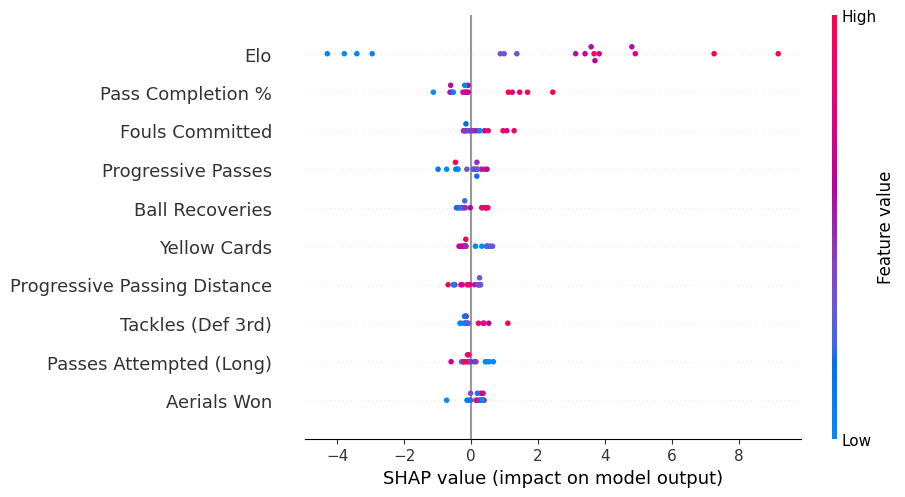

In [14]:
import shap
import numpy as np
import pandas as pd

# Extract model and transformed data
xgb_model = xgb_pipeline.named_steps["regressor"]
X_transformed = xgb_pipeline.named_steps["preprocessor"].transform(X_test)

# Extract feature names used in preprocessing
feature_names = xgb_pipeline.named_steps["preprocessor"].transformers_[0][2]

# Convert transformed data to DataFrame with proper column names
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_transformed_df)

# Compute mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Get indices of top 10 features
top_10_indices = np.argsort(mean_abs_shap)[-10:]

# Filter SHAP values to top 10 features
shap_values_top = shap_values[:, top_10_indices]

# Plot SHAP summary (beeswarm) for top 10 features
shap.plots.beeswarm(shap_values_top)


### Modelling Results 

In [43]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by MAE (ascending)
results_df_sorted = results_df.sort_values(by="MAE", ascending=True)

# Display selected columns (optional)
display_cols = ["Model", "MAE", "RMSE", "5-CV", "R2"]
print(results_df_sorted[display_cols])

                             Model       MAE      RMSE      5-CV        R2
22  ElasticNet (Top20 SelectKBest)  1.585666  2.200577  3.123690  0.729410
13  ElasticNet (Top20 SelectKBest)  1.857074  2.652824  3.123690  0.651980
18  ElasticNet (Top20 SelectKBest)  2.018275  2.877169  3.123690  0.625490
16  ElasticNet (Top20 SelectKBest)  2.046726  2.886951  3.123690  0.502958
29  ElasticNet (Top20 SelectKBest)  2.071212  2.655406  3.123690  0.571893
2   ElasticNet (Top20 SelectKBest)  2.141836  2.672848  3.123690  0.593092
31  ElasticNet (Top20 SelectKBest)  2.220104  2.833652  3.123690  0.563970
23  ElasticNet (Top20 SelectKBest)  2.317458  2.961911  3.123690  0.394032
15  ElasticNet (Top20 SelectKBest)  2.334530  2.945320  3.123690  0.504927
33  ElasticNet (Top20 SelectKBest)  2.371344  3.610731  3.123690  0.207779
0                            Lasso  2.377336  3.399100  2.886456  0.460047
25  ElasticNet (Top20 SelectKBest)  2.387191  3.235056  3.123690  0.602032
21  ElasticNet (Top20 Sel

### Model Saving & Shap Plots

In [44]:
import joblib

# Get the best model (lowest MAE)
best_model = results_df_sorted.iloc[0]["Pipeline"]

# Save to disk
joblib.dump(best_model, "best_model_cb.joblib")

['best_model_cb.joblib']

In [45]:
elastic = best_model.named_steps['elasticnetcv'] if 'elasticnetcv' in best_model.named_steps else best_model[-1]

# Get the StandardScaler (inside the ColumnTransformer)
preprocessor = best_model.named_steps['preprocess']

# 1. Get the list of actually used features:
feature_names = preprocessor.transformers_[0][2]  # This gets the feature names for 'num'

# 2. Coefficients from the model
coefs = elastic.coef_

# 3. Make sure lengths match
print(f"Feature names: {len(feature_names)}, Coefs: {len(coefs)}")

# 4. Now make the DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', key=abs, ascending=False)

print(importance_df)


Feature names: 20, Coefs: 20
                         feature  coefficient
19                           Elo     2.522544
2              Pass Completion %     0.502510
4             Progressive Passes     0.484100
1                        Assists     0.303577
15                     Red Cards    -0.300345
3       Pass Completion % (Long)     0.172190
0                          Goals     0.141190
5   Progressive Passing Distance     0.130760
7                  Shots Blocked    -0.078018
8              Tackles (Def 3rd)     0.009560
9              Tackles (Mid 3rd)    -0.000000
6        Passes Attempted (Long)    -0.000000
11                   Aerials Won    -0.000000
12               Ball Recoveries     0.000000
13               Fouls Committed    -0.000000
14                  Yellow Cards    -0.000000
16             Touches (Def 3rd)    -0.000000
17        GCA (Defensive Action)     0.000000
18        SCA (Defensive Action)     0.000000
10                       Tkl+Int     0.000000


In [46]:
# Transform X_train with your pipeline up to the estimator
X_proc = best_model.named_steps['preprocess'].transform(X_train[feature_names])

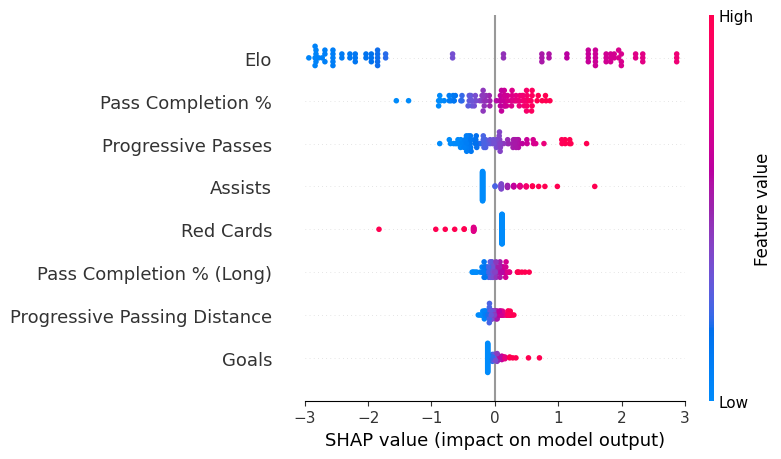

In [48]:
import shap
import matplotlib.pyplot as plt

explainer = shap.LinearExplainer(elastic, X_proc, feature_perturbation="interventional")
shap_values = explainer(X_proc)

plt.figure(figsize=(6, 8))  # Adjust for better horizontal space if needed
shap.summary_plot(
    shap_values, 
    features=X_proc, 
    feature_names=feature_names, 
    show=False, 
    max_display=8  # <-- Only show top 6 features
)
plt.xlim(-3, 3)
plt.show()
